## INFO

This is a notebook to highlight the Tweedie Compound Poisson Gamma (TCPG) ealstic net that was developed byt he Data Science team based on the following:

- https://cran.r-project.org/web/packages/HDtweedie/HDtweedie.pdf
- https://www.math.mcgill.ca/yyang/resources/papers/JCGS_HDtweedie.pdf

The elastic net code should be provided as well and it uses a "Fish" data set that is considered a useful test set. 

Please note that TCPG is only valid for solutions of powers between 1.0 and 2.0.

<font color=red size=4>**This version is straight  forward and only compares results.**</font>


<font color=blue size=4>**Links for comparison to SAS:**</font>

- https://stats.stackexchange.com/questions/400663/sas-and-r-gives-different-standard-error-when-fitting-tweedie-model

- *GEE Models not available for Tweedie Distribution*

In [1]:
## SOME EXTENSIONS MIGHT NOT LOAD 
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sidetable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sma

from sklearn.metrics import mean_tweedie_deviance, mean_absolute_error

import os
import gc

import shap
import eli5

pd.set_option('max_columns', 150)
pd.set_option('max_rows', 100)

In [3]:
import os
##  you must then set your R HOME before importing the module - it should be in a similar location as below

os.environ['R_HOME'] = 'C:/Users/schillw/Anaconda3/envs/fnb/Lib/R'


**As long as the environment part of the path above - the "fnb" matches your environment that you are working in.**

In [4]:
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2 import robjects
import rpy2
pandas2ri.activate()

import sys
print("Python version should be 3.7.9.")
print("Current Python Version: {}".format(sys.version))
print("rpy2 Version = ", rpy2.__version__)

print("\nR VERSION = ", r.version)

Python version should be 3.7.9.
Current Python Version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
rpy2 Version =  3.4.5

R VERSION =                 _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          3                           
minor          6.3                         
year           2020                        
month          02                          
day            29                          
svn rev        77875                       
language       R                           
version.string R version 3.6.3 (2020-02-29)
nickname       Holding the Windsock        



## Fish Data

I cant find the link but there are 5 variables where FISH_COUNT is our dependent variable based on how many were caught.

In [5]:
fish_data = pd.read_csv('data/fish.csv')
fish_data.head()

LIVE_BAIT  CAMPER  PERSONS  CHILDREN  FISH_COUNT
0          0       0        1         0           0
1          1       1        1         0           0
2          1       0        1         0           0
3          1       1        2         1           0
4          1       0        1         0           1

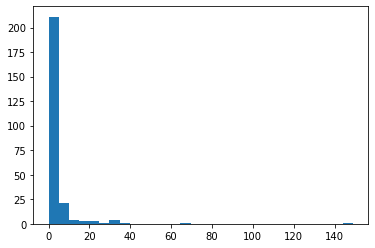

In [6]:
xf = fish_data.drop('FISH_COUNT',axis=1)
yf = fish_data['FISH_COUNT']

plt.hist(yf, bins=30);

**Here we see the distribution of the fishing data highlighting that it has a mass at zero and is discrete.**

In [7]:
(yf == 0).sum() / len(yf)

0.568

The data is about 56.8% 0.

**We must scale the exogenous variables (all others but y) to get an accurate assessment.**

In [8]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X = xf.copy() #ss.fit_transform(xf) #x.values
y = yf.values.reshape(-1,1)

xfs = pd.DataFrame(X, columns=xf.columns, index=xf.index)

xf.describe()

LIVE_BAIT      CAMPER    PERSONS    CHILDREN
count  250.000000  250.000000  250.00000  250.000000
mean     0.864000    0.588000    2.52800    0.684000
std      0.343476    0.493182    1.11273    0.850315
min      0.000000    0.000000    1.00000    0.000000
25%      1.000000    0.000000    2.00000    0.000000
50%      1.000000    1.000000    2.00000    0.000000
75%      1.000000    1.000000    4.00000    1.000000
max      1.000000    1.000000    4.00000    3.000000

### STATSMODELS - PYTHON

In [9]:
sas_power = 1.4023

twd = sma.GLM(endog=y, exog=sma.add_constant(xfs), 
              family=sma.families.Tweedie(var_power=sas_power, eql=True))

print("="*20," Normal Fit ","="*20)
tfit = twd.fit(maxiter=1000, tol=1e-12)
print(tfit.cov_type)
print(tfit.summary())

print("="*20," HC3 Fit ","="*20)
tfit_hc3 = twd.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
print(tfit_hc3.cov_type)
print(tfit_hc3.summary().tables[1])

print("="*20," HAC (NeweyWest) Fit ","="*20)
tfit_nw = twd.fit(cov_type='HAC', cov_kwds={'maxlags':12}, maxiter=1000, tol=1e-12)
print(tfit_nw.cov_type)
print(tfit_nw.summary().tables[1])

====================  Normal Fit  ====================
nonrobust
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  250
Model:                            GLM   Df Residuals:                      245
Model Family:                 Tweedie   Df Model:                            4
Link Function:                    log   Scale:                          7.6404
Method:                          IRLS   Log-Likelihood:                -554.54
Date:                Thu, 03 Mar 2022   Deviance:                       841.62
Time:                        17:28:57   Pearson chi2:                 1.87e+03
No. Iterations:                    18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [10]:
# tfit.wald_test(tfit.resid_working)

### Comparison with R

link.power = 0 is the log link

**R Code:**

library(tweedie)
library(statmod)
library(lmtest)
library(sandwich)

df <- read.csv(data='data/fish.csv')

m1 <- glm(FISH_COUNT~., data=df, family=tweedie(var.power=1.4, link.power=0))

summary(m1)

coeftest(m1, vcov=vcovHC(m1, type='HC3'))

coeftest(m1, vcov=NeweyWest(m1, lag=12, prewhite=F))

In [11]:
from statsmodels.iolib import SimpleTable
from statsmodels.iolib.tableformatting import (gen_fmt, fmt_2, fmt_params)

In [12]:
def r_summary_model(model, X):
    """ Create a dict with information about the model """
    import datetime as dt
    from statsmodels.iolib import SimpleTable
    from statsmodels.iolib.tableformatting import (gen_fmt, fmt_2, fmt_params)
    from statsmodels.iolib.summary import forg
#         model = self.model

    info = {}
    info['Model:'] = 'Tweedie with Varying Error Types'
    info['Date:'] = dt.datetime.now().strftime('%Y-%m-%d %H:%M')
    info['Df Model:'] = rbase.summary(model).rx2('df')[0]
    info['Df Residuals:'] = model.rx2('df.residual')[0]
#     info['Converged:'] = rbase.summary(model).rx2('converged')[0]
    info['Deviance:'] = rbase.summary(model).rx2('deviance')[0]
    info['Dispersion:'] = rbase.summary(model).rx2('dispersion')[0]
    info['Iters:'] = rbase.summary(model).rx2('iter')[0]

    out = pd.DataFrame(info, index=range(len(info))).T.iloc[:,0]
    model_coefs = rbase.summary(model).rx2('coefficients')
    orig_data = model.rx2('model')
    var_names = ['Intercept'] + list(X.columns) #self.X.columns)
    
    cov = rbase.summary(model).rx2('cov.scaled')

    model_data = list(info.items())
    mt = SimpleTable(model_data, txt_fmt=fmt_params)

    params_data = []
    for i in range(model_coefs.shape[0]):
        curr_row = model_coefs[i,:]
#         params_data.append([forg(j, prec=4) for j in curr_row])
        params_data.append([np.round(j,5) for j in curr_row])
    pt = SimpleTable(params_data, ['Estimate', 'Std. Error', 't value', 'Pr(>|t|)'],
                     var_names, txt_fmt=fmt_params)
    return mt, pt

In [13]:
mass = importr('MASS')
rstats = importr('stats')
robustbase = importr('robustbase')
rbase = importr('base')
rsm = importr('statmod')
rsw = importr('sandwich')
r_lmt = importr('lmtest')

R object inheriting from "POSIXct" but without attribute "tzone".


In [14]:
yR = pd.Series(y.flatten())
yR.name = 'y'

rdf = pd.concat([yR,xfs], axis=1)
rdf.head()

y  LIVE_BAIT  CAMPER  PERSONS  CHILDREN
0  0          0       0        1         0
1  0          1       1        1         0
2  0          1       0        1         0
3  0          1       1        2         1
4  1          1       0        1         0

In [15]:
## tukey defaults are S=1.55, M=4.69
cntrl_str = '''maxit=1000'''
cntrl = robjects.r('a1 <- glm.control({})'.format(cntrl_str)) 

model = rstats.glm('{} ~ .'.format(yR.name), 
                  data=rdf, family=robjects.r('tweedie(var.power={}, link.power=0)'.format(sas_power)),
                  control=cntrl)
model_coefs = rbase.summary(model).rx2('coefficients')

In [16]:
print("R Model","="*30)
for item in r_summary_model(model, X):
    print(item)

print("Statsmodels","="*30)
print(tfit.summary().tables[1])

R Model ==============================
       Model: Tweedie with Varying Error Types
        Date:                 2022-03-03 17:29
    Df Model:                                5
Df Residuals:                              245
    Deviance:                841.6208938250044
  Dispersion:                7.640315118546264
       Iters:                                5
             Estimate Std. Error    t value   Pr(>|t|)
------------------------------------------------------
Intercept    -3.11477    0.72067   -4.32203      2e-05
LIVE_BAIT     1.58167    0.62332     2.5375    0.01179
CAMPER        0.64541    0.31049    2.07866    0.03869
PERSONS       1.05683    0.13264    7.96788        0.0
CHILDREN     -1.77527    0.24616   -7.21193        0.0
Statsmodels ==============================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1148      0.721     -4.322   

In [17]:
var_names = ['Intercept'] + list(xfs.columns)

hc3_params = r_lmt.coeftest(model, vcov=rsw.vcovHC(model, type="HC3"))

st = SimpleTable(hc3_params.round(4), ['Estimate', 'Std. Error', 't value', 'Pr(>|t|)'],
                 var_names, txt_fmt=fmt_params)

print("R Model","="*30)
print(st)
print("Statsmodels","="*30)
print(tfit_hc3.summary().tables[1])

R Model ==============================
             Estimate Std. Error    t value   Pr(>|t|)
------------------------------------------------------
Intercept     -3.1148     0.5111    -6.0943        0.0
LIVE_BAIT      1.5817     0.3869     4.0885        0.0
CAMPER         0.6454     0.3458     1.8662      0.062
PERSONS        1.0568     0.1196     8.8386        0.0
CHILDREN      -1.7753     0.2308    -7.6913        0.0
Statsmodels ==============================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1148      0.471     -6.614      0.000      -4.038      -2.192
LIVE_BAIT      1.5817      0.372      4.249      0.000       0.852       2.311
CAMPER         0.6454      0.337      1.913      0.056      -0.016       1.307
PERSONS        1.0568      0.116      9.145      0.000       0.830       1.283
CHILDREN      -1.7753      0.241     -7.362      0.000     

In [18]:
nw_params = r_lmt.coeftest(model, vcov=rsw.NeweyWest(model, lag=12))

st = SimpleTable(nw_params.round(4), ['Estimate', 'Std. Error', 't value', 'Pr(>|t|)'],
                 var_names, txt_fmt=fmt_params)

print("R Model","="*30)
print(st)
print("Statsmodels","="*30)
print(tfit_nw.summary().tables[1])

R Model ==============================
             Estimate Std. Error    t value   Pr(>|t|)
------------------------------------------------------
Intercept     -3.1148     0.4899    -6.3585        0.0
LIVE_BAIT      1.5817     0.3295     4.7998        0.0
CAMPER         0.6454     0.3071     2.1016     0.0356
PERSONS        1.0568     0.1131      9.342        0.0
CHILDREN      -1.7753     0.2196    -8.0835        0.0
Statsmodels ==============================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1148      0.478     -6.519      0.000      -4.051      -2.178
LIVE_BAIT      1.5817      0.331      4.773      0.000       0.932       2.231
CAMPER         0.6454      0.305      2.116      0.034       0.048       1.243
PERSONS        1.0568      0.113      9.316      0.000       0.834       1.279
CHILDREN      -1.7753      0.235     -7.547      0.000     

In [19]:
tfit_nw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                            GLM   Df Residuals:                      245
Model Family:                 Tweedie   Df Model:                            4
Link Function:                    log   Scale:                          7.6404
Method:                          IRLS   Log-Likelihood:                -554.54
Date:                Thu, 03 Mar 2022   Deviance:                       841.62
Time:                        17:29:21   Pearson chi2:                 1.87e+03
No. Iterations:                    18                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1148      0.478     -6.519      0.000      -4.051      -2.178
LIVE_BAIT      1.5817      0.331      4.773      0.000       0.932       2.231
CAMPER         0.6454      0.305      2.116      0.034       0.048       1.243
PERSONS        1.0568      0.113      9.316      0.000       0.834       1.279
CHILDREN      -1.7753      0.235     -7.547      0.000      -2.236      -1.314
==============================================================================
"""

In [28]:
os.getcwd()

'C:\\Users\\schillw\\OneDrive - FNBCorp\\CECL 2020-2021\\tweedie_huber_info_v2'

In [51]:
def tweedie_rout(y, X, power, path, segment):
    '''Writes an R script for ease of checking to the specified path portion.
       The path already pulls in the current working directory of the notebook.
       Returns the r_data and the script.
    '''
    import os

    cwd = os.getcwd()
    data = pd.concat([y,X],axis=1).dropna()
    data.to_csv(cwd+path+'/r_data.csv', index=False)

    y_name = data.columns[0]

    script = '''
        Packages <- c("tweedie", "statmod", "lmtest", "sandwich")
        lapply(Packages, library, character.only = TRUE)

        print("Read in the data ===================")
        df <- read.csv(file='r_data.csv')
        print("Run the Model ======================")
        m <- glm('{}~.', data=df, family=tweedie(var.power={}, link.power=0))
        print("Summary ============================")
        summary(m)
        print("Newey-West Robust Errors ===========")
        coeftest(m, vcov=NeweyWest(m, lag=12, prewhite=F))
        '''.format(y_name, power)

    with open(cwd+path+'/r_code_{}.r'.format(segment), 'w') as f:
        f.write(script)

    return data, script

In [52]:
tweedie_rout(yR, xfs, 1.4, path='/r_out_test', segment='test')

(     y  LIVE_BAIT  CAMPER  PERSONS  CHILDREN
 0    0          0       0        1         0
 1    0          1       1        1         0
 2    0          1       0        1         0
 3    0          1       1        2         1
 4    1          1       0        1         0
 ..  ..        ...     ...      ...       ...
 245  0          1       1        2         0
 246  0          1       1        4         3
 247  0          1       1        2         1
 248  0          1       1        3         2
 249  0          1       1        2         1
 
 [250 rows x 5 columns],
 '\n        Packages <- c("tweedie", "statmod", "lmtest", "sandwich")\n        lapply(Packages, library, character.only = TRUE)\n\n        print("Read in the data ===================")\n        df <- read.csv(file=\'r_data.csv\')\n        print("Run the Model ======================")\n        m <- glm(\'y~.\', data=df, family=tweedie(var.power=1.4, link.power=0))\n        print("Summary ============================")\

In [ ]:
break